# Garments Classification Model

## Import Requirements

In [32]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import fastbook as fb
import gc
import pandas as pd
import pickle
import numpy as np
from pathlib import Path

%matplotlib inline

## Import dataset

In [2]:
list_cloth_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_cloth.txt"
list_img_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_img.txt"

df_cloth=pd.read_csv(list_cloth_path,skiprows=1,delim_whitespace=True)
df_img=pd.read_csv(list_img_path,skiprows=1,delim_whitespace=True)

In [3]:
df_cloth.to_dict()
category_map = df_cloth
category_map["value"] = category_map.index + 1

In [4]:
dict_category = category_map.set_index("value").to_dict()["category_name"]
dict_cloth = category_map.set_index("category_name").to_dict()["category_type"]

In [5]:
df = df_img
df["category_label"] = df["category_label"].map(dict_category)
df["garment_type"] = df["category_label"].map(dict_cloth)

In [6]:
df["image_name"] = df["image_name"].str.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/")

In [8]:
df

,image_name,category_label,garment_type
0,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,1
1,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,1
2,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse,1
3,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,1
4,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse,1
...,...,...,...
289217,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress,3
289218,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress,3
289219,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress,3
289220,DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000053.jpg,Dress,3


In [7]:
shoe_df = pd.DataFrame(columns = ['image_name', 'category_label'])

root = "../Dataset/EdgeNet_Shoe_DS/training/"
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

for category_name in dirlist:
    route = root + category_name + "/"
    
    directory = os.fsencode(route)

    for file in os.listdir(directory): #for cycle to iterate over folder
        filename = os.fsdecode(file) #get file name
        if filename.endswith(".jpg"): #if ends with .jpg
            shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)

/tmp/ipykernel_208/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_208/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_208/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykerne

In [8]:
with open('../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/train.txt') as f:
    train_list = f.read().splitlines()

train_list = [row.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/") for row in train_list]

cloth_df = df[df["image_name"].isin(train_list)].drop("garment_type",axis=1)

frames = [cloth_df,shoe_df]

complete_df = pd.concat(frames)

complete_df.to_csv("../Dataset/train_list.csv",index=False)

## Image Load

In [33]:
PATH = "../Dataset/"
TRAINING_PATH = "train_list.csv"

data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)

In [34]:
gc.collect()
torch.cuda.empty_cache()

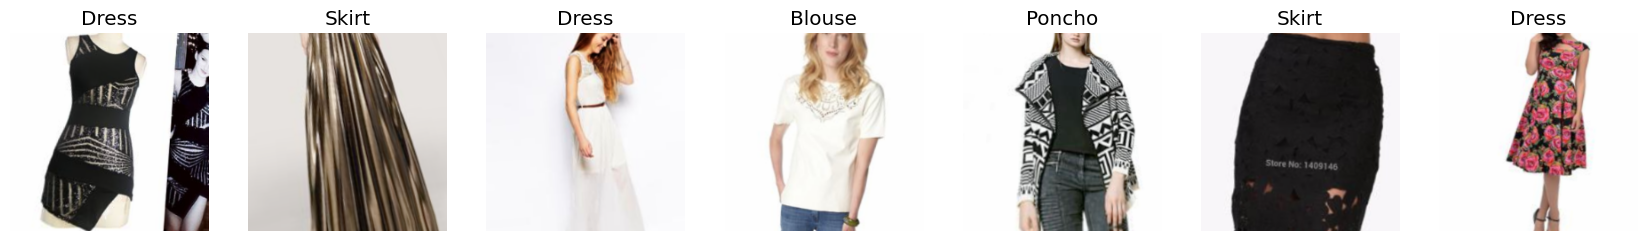

In [35]:
data.show_batch(max_n=7, nrows=1)

## Model Training

In [36]:
learn = cnn_learner(data, resnet34, metrics=[accuracy,error_rate], pretrained=True)
learn.fine_tune(3)
learn.save('stage-1_resnet34')

/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.996005,1.959812,0.511740,0.488260,02:41


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.045230,1.562393,0.583564,0.416436,03:33
1,1.617707,1.421272,0.600829,0.399171,03:31
2,1.346998,1.377996,0.627762,0.372238,03:34


Path('../Dataset/models/stage-1_resnet34.pth')

In [37]:
gc.collect()
torch.cuda.empty_cache()

### Learning rate finder

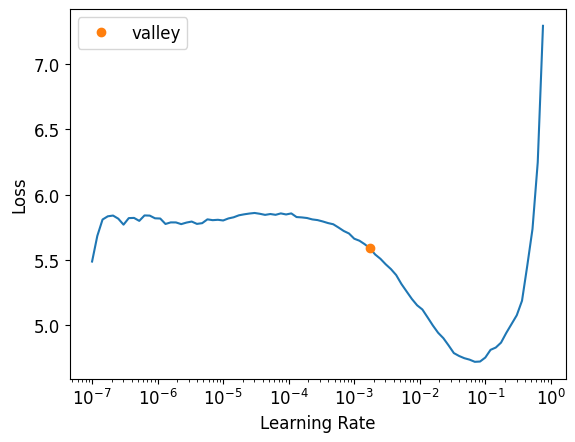

In [38]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_steep = learn.lr_find()

In [39]:
lr_steep

SuggestedLRs(valley=0.001737800776027143)

In [40]:
gc.collect()
torch.cuda.empty_cache()

In [41]:
learn.fine_tune(8, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.578429,1.819737,0.502072,02:39


epoch,train_loss,valid_loss,accuracy,time
0,1.787763,1.506313,0.576657,03:26
1,1.672801,1.422462,0.592541,03:27
2,1.562628,1.468158,0.587017,03:30
3,1.396095,1.465579,0.593232,03:34
4,1.215464,1.344985,0.635359,03:33
5,0.990458,1.336381,0.647790,03:33
6,0.777814,1.343333,0.647099,03:34
7,0.676133,1.352060,0.656768,03:34


### Discriminative Learning Rates

In [42]:
gc.collect()
torch.cuda.empty_cache()

In [43]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

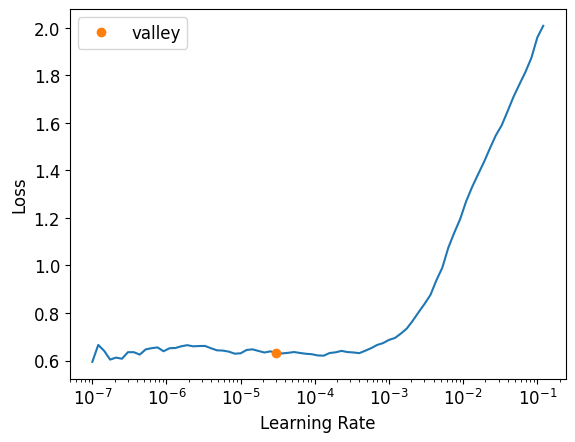

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.627848,1.414951,0.647790,03:32
1,0.668369,1.470416,0.639503,03:32
2,0.622668,1.506883,0.634669,03:29
3,0.558565,1.513810,0.638122,03:29
4,0.550123,1.547638,0.636740,03:34
5,0.538918,1.532081,0.630525,03:35


SuggestedLRs(valley=6.30957365501672e-05)

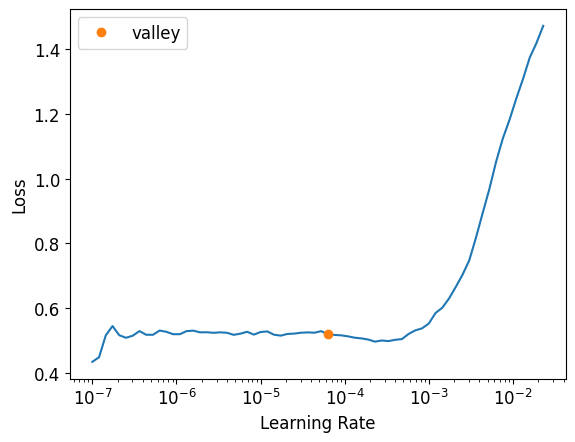

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.533233,1.580465,0.637431,03:38
1,0.530306,1.629471,0.624309,03:35
2,0.512535,1.604825,0.643646,03:38


### Export model

In [48]:
#modelname = learn.model
#modelname.cpu()
#torch.save(modelname, '../Model/stage-1_resnet34.pkl')
learn.export("../Model/stage-1_resnet34.pkl")

## Evaluation

### Mappings

In [9]:
category_dict = {
    "top":      1,
    "bottom":   2, 
    "shoes":    3,
    "onepiece": 4   # ignored in the MVP version
}

formality_dict = {
    "formality":3,
    "casual":2, 
    "sport":1
}

weather_dict = {
    "cold":3,
    "sunny":2, 
    "rainny":1
}

type_dict = {    # category, formality, weather
"Anorak" :        (1, 1, 3),
"Blazer":         (1, 3, 2),
"Blouse":         (1, 2, 2),
"Bomber" :        (1, 2, 3),
"Button-Down":    (1, 2, 2 ),
"Cardigan" :      (1, 2, 3),
"Flannel" :       (1, 2, 3),
"Halter":         (1,2,2),
"Henley" :        (1, 2,3),
"Hoodie" :        (1, 2, 3),
"Jacket" :        (1, 2, 3),
"Jersey"  :       (1, 1, 2),
"Parka"   :       (1,2,3),
"Peacoat" :       (1,3,3),
"Poncho" :        (1,2,3),
"Sweater"  :      (1,2,3),
"Tank" :          (1,3,2),
"Tee" :           (1,2,2),
"Top"  :          (1,2,2),
"Turtleneck" :    (1,3,3),
"Capris" :        (2,2,2),
"Chinos"  :       (2,2,2),
"Culottes"  :     (2,2,2),
"Cutoffs" :       (2,2,2),
"Gauchos"  :      (2,2,2),
"Jeans" :         (2,2,2),
"Jeggings" :      (2,2,2),
"Jodhpurs"  :     (2,1,2),
"Joggers"  :      (2,1,3),
"Leggings"  :     (2,1,2),
"Sarong"  :       (2,2,2),
"Shorts"  :       (2,2,2),
"Skirt"   :       (2, 2,2),
"Sweatpants" :    (2, 1, 3),
"Sweatshorts" :   (2, 1, 2 ),
"Trunks"       :  (2, 1, 2),
"Caftan"       :  (4,3,2),
"Cape"         :  (4,3,3),
"Coat"         :  (4, 3, 3),
"Coverup"      :  (4, 2, 2),
"Dress"        :  (4, 2, 2),
"Jumpsuit"     :  (4, 2, 2),
"Kaftan"        : (4, 3, 2),
"Kimono"         :(4, 3, 2),
"Nightdress"     :(4, 2, 2),
"Onesie"         :(4, 2, 2),
"Robe"           :(4, 2, 2),
"Romper"       :  (4, 2, 2),
"Shirtdress"    : (4, 2, 2),
"Sundress"     :  (4, 2, 2),
"boots":(3, 2, 3) ,
"flip_flops":(3, 2, 3),
"loafers":(3, 3, 2),
"sandals":(3, 2, 2),
"sneakers":(3, 2, 2),
"soccer_shoes":(3,1,2)}

In [10]:
inv_category_dict = dict(zip(category_dict.values(), category_dict.keys()))
inv_formality_dict = dict(zip(formality_dict.values(), formality_dict.keys()))
inv_weather_dict = dict(zip(weather_dict.values(), weather_dict.keys()))

In [11]:
type_df = pd.DataFrame(type_dict).T
type_df.columns = ['Garment_type', 'Formality', 'Weather']

In [12]:
type_df["Garment_type"]=type_df["Garment_type"].map(inv_category_dict)
type_df["Formality"]=type_df["Formality"].map(inv_formality_dict)
type_df["Weather"]=type_df["Weather"].map(inv_weather_dict)

### Predict

In [50]:
pred_df = pd.DataFrame(columns=["image_name","category_label","pred_category_label","garment_type","formality","weather"])

In [51]:
pred_df["image_name"] = complete_df["image_name"]
pred_df["category_label"] = complete_df["category_label"]

In [52]:
pred_df = pred_df.drop(pred_df[pred_df["category_label"]=="Dress"].index)

In [54]:
pred_df.reset_index().drop(["index"], axis=1)

,image_name,category_label,pred_category_label,garment_type,formality,weather
0,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000012.jpg,Blouse,NaN,NaN,NaN,NaN
1,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000020.jpg,Blouse,NaN,NaN,NaN,NaN
2,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000072.jpg,Blouse,NaN,NaN,NaN,NaN
3,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000122.jpg,Blouse,NaN,NaN,NaN,NaN
4,DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000124.jpg,Blouse,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
10459,EdgeNet_Shoe_DS/training/sneakers/image189.jpg,sneakers,NaN,NaN,NaN,NaN
10460,EdgeNet_Shoe_DS/training/sneakers/image24.jpg,sneakers,NaN,NaN,NaN,NaN
10461,EdgeNet_Shoe_DS/training/sneakers/image18.jpg,sneakers,NaN,NaN,NaN,NaN
10462,EdgeNet_Shoe_DS/training/sneakers/image242.jpg,sneakers,NaN,NaN,NaN,NaN


In [55]:
learn = load_learner('../Model/stage-1_resnet34.pkl')

In [56]:
permuted_indices = np.random.permutation(len(pred_df))
N_PARTITIONS = 5
dfs = []
for i in range(N_PARTITIONS):
    dfs.append(pred_df.iloc[permuted_indices[i::N_PARTITIONS]])

In [57]:
dfs[0]

,image_name,category_label,pred_category_label,garment_type,formality,weather
45113,DeepFashion_DS/DeepFashion_DS_IMG/Striped_Ringer_Tee/img_00000037.jpg,Tee,NaN,NaN,NaN,NaN
63137,DeepFashion_DS/DeepFashion_DS_IMG/Champagne_Slub_Knit_Top/img_00000020.jpg,Top,NaN,NaN,NaN,NaN
187280,DeepFashion_DS/DeepFashion_DS_IMG/Shirred_Sateen_Maxi_Skirt/img_00000006.jpg,Skirt,NaN,NaN,NaN,NaN
29721,DeepFashion_DS/DeepFashion_DS_IMG/Prairie-Embroidered_Peplum_Blouse/img_00000043.jpg,Blouse,NaN,NaN,NaN,NaN
3386,DeepFashion_DS/DeepFashion_DS_IMG/Tab-Sleeved_Chiffon_Blouse/img_00000072.jpg,Blouse,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
116957,DeepFashion_DS/DeepFashion_DS_IMG/Marled_Dolman-Sleeve_Hoodie/img_00000007.jpg,Hoodie,NaN,NaN,NaN,NaN
90615,DeepFashion_DS/DeepFashion_DS_IMG/Faux_Leather-Paneled_Denim_Jacket/img_00000037.jpg,Jacket,NaN,NaN,NaN,NaN
92845,DeepFashion_DS/DeepFashion_DS_IMG/Fitted_Cat_Print_Tee/img_00000009.jpg,Tee,NaN,NaN,NaN,NaN
189835,DeepFashion_DS/DeepFashion_DS_IMG/Embroidered_Denim_Shorts/img_00000028.jpg,Shorts,NaN,NaN,NaN,NaN


In [59]:
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
cont = 1
avance = 1
for slice_pred_df in dfs:
    for image in slice_pred_df["image_name"]:
        image_path = "../Dataset/"+image
        slice_pred_df.loc[slice_pred_df["image_name"]==image,"pred_category_label"]=learn.predict(image_path)[0]
        gc.collect()
        torch.cuda.empty_cache()
        print(avance)
        avance+=1
    filepath = Path("Development/Predicted_DF/"+"pred_df"+str(cont)+".csv") 
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    slice_pred_df.to_csv(filepath,index=False)
    cont+=1
    gc.collect()
    torch.cuda.empty_cache()